# How to Analyze an Experiment that Didn't Work

## Motivation:

We want to be able to answer questions such as:

* How many times can I use this tool before it breaks?
* When are people most likely to cash in a gift card they got for Christmas?
* How many of our products will have a repair in the 2-year warranty window?

* Which members are likely to have surgery within 6-18 months?

| Member | Time to Surgery | Label |
| --- | --- | --- |
| Al | 5 months, 29 Days | False |
| Betty | 6 months, 1 Day | True |
| Charlie | 17 months 29 Days | True |
|Debroah | 18 months 1 Day | False |

* Al and Betty have very similar outcomes but are markeed as completely opposite.
* Betty and Charlie differ by almost a year, but are considered to have identical outcomes
* Charle and Deborah have very similar outcomes, but are marked as complete opposites
* Al and Deborah are the most different of all, yet have the same label

## Approach:

We are trying to predict when an event is going to happen. We start by assuming that it is a simple random event with a fixed probability of happening in any time interval or attempt.

We can model this as a die with an unknown number of sides. 
![image of dice with many sides](dice.png)
Our event happens when we roll a 1. If we roll anything else, the event does not happen.

We want to know how many times we should expect to roll it before we get a one.

This is a *Bernoulli* process with an unknown but constant probability *p* of success on each roll.

The probability of success on each roll is $$p = \frac{1}{\text{number of sides}}$$

So if we have a 40-sided die, the probability of rolling a one each time we roll it is 
$$p = \frac{1}{40} = 0.025$$

The probability of *not* getting a one is $$q = 1-p$$

Generally, we're going to need to roll it a bunch of times until we get a one.
The probability of rolling it *n* times in a row without getting a one is:

$$P(\text{not getting a one in n attempts}) = q^n$$

And the probability of getting a one on our $n^{th}$ attempt is:

$$q^{n-1}\cdot p$$
or
$$(1-p)^{n-1}\cdot p$$

This is the geometric distribution.

The Expecetation value of the geometric distribution is $1/p$ or, the average number of attempts needed to roll a 1.

So, if we want to know how many sides our die has (or how probable our event is) all we have to do is roll the die until we get a one. The number of rolls indicates the number of sides.

Unfortunately, there's a pretty wide variation in how many rolls it is likely to take to roll a one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, geom

Here we have an event that happens on average once per year, or equivalently, a die with 365 sides.

The 90th percentile confidence interval, (the range of "normal" outcomes) can vary widely:

In [2]:
np.percentile(geom(p:=1/365).rvs(10000), (5,95))

array([  20., 1076.])

Rolling this die once isn't going to work.
So, to improve our estimate of the number of sides, we repeat this experiment many times and take the average:

In [15]:
[(i,geom(p).rvs(int(i)).mean()) for i in np.logspace(1,5,5)]

[(10.0, 202.3),
 (100.0, 313.96),
 (1000.0, 386.722),
 (10000.0, 369.05),
 (100000.0, 364.43207)]

In [22]:
np.percentile([geom(p).rvs(10000).mean() for _ in range(500)], (5, 90))

array([358.77836, 369.34395])

In [23]:
np.percentile([geom(p).rvs(100000).mean() for _ in range(500)], (5, 90))

array([363.1493745, 366.579881 ])

#### This is the very best way to get a good estimate of the probability of the event.

The problem is it can take a lot of time and resources.

To get this estimate, we had to roll the die 36 million times.

In [25]:
geom(p).rvs(100000).sum()

3658544

In [26]:
geom(p).rvs(100000).max()

4393

## How can we get the same quality of estimate with many fewer rolls?

## What if we are constrained in how many rolls we can attempt?

### Suppose we have a 40-sided die, but we are limited to only rolling each die 30 times.

#### This means a lot of our trials will end without ever rolling a one. How should we record these results?

* Ignore them. If we never observed a result, we can't use that trial
* Assume they would have produced a one on the next roll
* Assume they would produce a r

In [34]:
rolls = geom(1/40).rvs(100)
observations = np.where(rolls<=30, rolls, np.nan)
observations

array([nan, nan, nan, nan, 23., nan, 11., 21.,  8., nan, nan,  1.,  4.,
       nan, 24., 29., 11., nan, 27., 17., 10., nan, nan, nan, 27., nan,
       nan, nan, nan,  4.,  4., nan,  5., nan,  3.,  3., 16., nan, 27.,
       13.,  8.,  2., nan, nan, 24., 10., nan,  2., nan, 16., nan, nan,
       23., 18., 24., nan, nan,  2.,  3., 10.,  8.,  7., nan,  2., 28.,
        5., nan, 19., nan, nan, nan, 17.,  8., 29., nan,  6., nan, 12.,
       25., nan,  6.,  3., nan, nan, 26.,  1., 17., 19., nan, 22.,  8.,
       nan, 26., 16.,  1., nan, nan,  7., 24.,  1.])

In [37]:
Q = np.isnan(observations).mean()
30 + 1/(1-(Q)**(1/30))


64.14992310468108

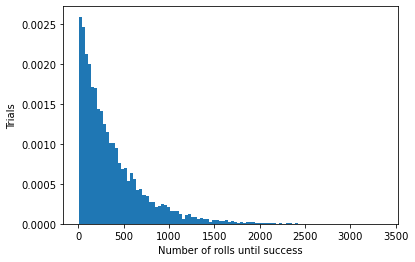

In [31]:
plt.hist(geom(p).rvs(10000), bins=100, density=True)
plt.xlabel('Number of rolls until success')
plt.ylabel('Trials');